# Загрузка и обработка изначального датасета

## EDA

In [3]:
import pandas as pd
import numpy as np
import warnings
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

# Ignore all warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_feather('updated_data_communication.feather')

In [5]:
df.sort_values(['client_id','delivery_date','merge_date'], inplace= True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21127 entries, 9374 to 10523
Columns: 3911 entries, merge_date to datetimekey
dtypes: category(1), datetime64[ns](2), float32(3408), float64(4), object(496)
memory usage: 355.8+ MB


In [7]:
# основные поля
cols = ['client_id','delivery_date', 'sp_createdon','merge_date','report_date_expon'
        ,'report_date_crm','camp_id','agr_id','agreement_dttm']

In [8]:
df['delivery_date'] = pd.to_datetime(df.delivery_date)
df['sp_createdon'] = pd.to_datetime(df.sp_createdon)
df['agreement_dttm'] = pd.to_datetime(df.agreement_dttm)

In [9]:
df['name_of_month'] = df['sp_createdon'].dt.month_name()

In [10]:
print(f'{len(df)} строк ')
print(f'{len(df.columns)} полей ')
print(f'{df.client_id.nunique()} юзеров, из которых {df[df.agreement_dttm.notna()].client_id.nunique()} с договором')
print(f'Коммуникации с {df.delivery_date.min()} до {df.delivery_date.max()}')
print(f'Сделки с {df.agreement_dttm.min()} до {df.agreement_dttm.max()}')

21127 строк 
3912 полей 
15903 юзеров, из которых 579 с договором
Коммуникации с 2023-08-31 00:00:00 до 2024-04-01 00:00:00
Сделки с 2023-01-05 21:00:00 до 2024-04-28 21:00:00


## Фильтрация, убираем выбросы и готовим к виду для тренировки моделей

In [11]:
# самые свежие 0-60 дней
# 60-120,  120-180, 180 - 365

In [12]:
# по каким критериям оставляем
# дата договора >= дата доставки
df1 = df[(df.agreement_dttm.isna())|(df.agreement_dttm >= df.delivery_date)]

# оставляю только строки с sp_createdon >= '2023-08-15'
df1 = df1[df1.sp_createdon >= pd.to_datetime('2023-08-15')]

# разница между датами sp и смс
df1['date_diff'] = (df1['delivery_date'] - df1['sp_createdon']).dt.days
# оставляю только до 3 месяцев
# df1 = df1[df1.date_diff <= 120]

# не сработает, если несколько одинаковых sp_createdon, но сейчас всё ок
df1['max_sp_for_del_dt'] = df1.groupby(['client_id','delivery_date'])['sp_createdon'].transform(max)
# только последний sp
df1 = df1[df1.max_sp_for_del_dt == df1.sp_createdon]

In [13]:
df1['conv_flg'] = df1.client_id.isin(df1.client_id[df1.agreement_dttm.notna()].unique())
# 0. Выделяем дату договора
df1['real_agr_dttm'] = df1.groupby('client_id')['agreement_dttm'].transform(max)
# 1. Оставляем лишь строки с смс до даты подписания договора
df1 = df1[(~df1.conv_flg)|(df1.delivery_date < df1.real_agr_dttm)]
# 2. Берём минимальную sp за день 0
df1['min_sp_created_on'] = df1.groupby('client_id')['sp_createdon'].transform(min)
# 3. считаем от неё количество дней до delivery_date
df1['date_diff_sp_del'] = (df1['delivery_date'] - df1['min_sp_created_on']).dt.days

df1 = df1[df1.date_diff_sp_del <= 120]

df1['n_communications'] = df1.groupby('client_id')['delivery_date'].transform(len)
df1['previous_delivery_date'] = (df1.groupby(['client_id'])['delivery_date'].shift(1))
df1['diff_delivery'] = df1['delivery_date'] - df1['previous_delivery_date']
df1['diff_delivery_days'] = df1.diff_delivery.dt.days
df1['delivery_day_of_week'] = df1['delivery_date'].dt.day_name()

In [14]:
print(f'{len(df1)} строк ')
print(f'{len(df1.columns)} полей ')
print(f'{df1.client_id.nunique()} юзеров, из которых {df1[df1.agreement_dttm.notna()].client_id.nunique()} с договором')
print(f'Коммуникации с {df1.delivery_date.min()} до {df1.delivery_date.max()}')
print(f'Сделки с {df1.agreement_dttm.min()} до {df1.agreement_dttm.max()}')

11383 строк 
3923 полей 
10951 юзеров, из которых 103 с договором
Коммуникации с 2023-08-31 00:00:00 до 2024-04-01 00:00:00
Сделки с 2023-09-14 21:00:00 до 2024-04-28 21:00:00


In [15]:
# с наличием договора
df1[df1.conv_flg].groupby('client_id')['n_communications'].max().reset_index()['n_communications'].value_counts().sort_index()

n_communications
1    91
2    12
Name: count, dtype: int64

In [16]:
# без договора
df1[~df1.conv_flg].groupby('client_id')['n_communications'].max().reset_index()['n_communications'].value_counts().sort_index()

n_communications
1    10448
2      381
3       18
4        1
Name: count, dtype: int64

In [17]:
print(f" Средняя длина между коммуникациями = {(df1['diff_delivery']).mean()}")

 Средняя длина между коммуникациями = 49 days 04:00:00


In [18]:
print(f" Медианная длина между коммуникациями = {(df1['diff_delivery']).median()}")

 Медианная длина между коммуникациями = 46 days 00:00:00


## Генерим коммуникационные фичи

In [19]:
# Алгоритмы для таргета 1 и 0

In [20]:
# 
df_target = df1[['client_id','real_agr_dttm','min_sp_created_on'
                 ,'date_diff_sp_del','n_communications','conv_flg','diff_delivery_days'
                 ,'delivery_day_of_week','delivery_date']]
df_target

,client_id,real_agr_dttm,min_sp_created_on,date_diff_sp_del,n_communications,conv_flg,diff_delivery_days,delivery_day_of_week,delivery_date
9374,00015b188cd3369bf0b8c75aab89a79a,NaT,2023-11-30,89,1,False,NaN,Tuesday,2024-02-27
9506,0002fe1622dae9bbfac81cc82588ed4c,NaT,2023-12-10,93,1,False,NaN,Tuesday,2024-03-12
10020,000754cc7100eba156087a1b36b1425d,NaT,2023-11-02,47,1,False,NaN,Tuesday,2023-12-19
8656,000c50804b9a4d4a86e135ce4f0e4611,NaT,2023-11-27,120,1,False,NaN,Tuesday,2024-03-26
9781,000d3ef9517568ee9870b6719ff6beed,NaT,2023-11-02,1,2,False,NaN,Friday,2023-11-03
...,...,...,...,...,...,...,...,...,...
6544,ffd8f05916de5f98b012cc6270716dfd,NaT,2023-12-05,22,1,False,NaN,Wednesday,2023-12-27
9482,ffe4a84c4e824ecf73bc1113103a2702,NaT,2024-02-25,20,1,False,NaN,Saturday,2024-03-16
18326,fff558a93f3f573fb2db724478dd291e,NaT,2023-10-26,47,1,False,NaN,Tuesday,2023-12-12
20758,fff98bcaf733273bcc2403103414ccee,NaT,2023-11-26,53,1,False,NaN,Thursday,2024-01-18


In [21]:
# фичи -> количество коммуникаций, время от создания sp до первой коммуникации, среднее время между коммуникациями
# , наличие коммуникации в день N, наличие коммуникации в неделю N, коммуникация в выходной / будний день
# , количество коммуникаций в выходной / будний

In [22]:
from workalendar.europe import Russia
 
calend = Russia()
# все офиц. праздники
holidays = pd.DataFrame(calend.holidays(2023)+calend.holidays(2024))
holidays.columns = ['holiday_date','holiday_name']
holidays['holiday_date'] = pd.to_datetime(holidays.holiday_date)
holidays

,holiday_date,holiday_name
0,2023-01-01,New year
1,2023-01-02,Day After New Year
2,2023-01-03,Third Day after New Year
3,2023-01-04,Fourth Day after New Year
4,2023-01-05,Fifth Day after New Year
5,2023-01-06,Sixth Day after New Year
6,2023-01-07,Christmas
7,2023-01-08,Eighth Day after New Year
8,2023-02-23,Defendence of the Fatherland
9,2023-03-08,International Women's Day


In [23]:
df_target = pd.merge(df_target, holidays, left_on='delivery_date',right_on = 'holiday_date', how='left')
df_target['holiday_name'].fillna('not holiday', inplace = True)


In [24]:
one_hot_encoded = pd.get_dummies(df_target['date_diff_sp_del'], prefix='day',dtype=int)
days_nums_columns = one_hot_encoded.columns
df_target = pd.concat([df_target, one_hot_encoded], axis=1)

In [25]:
one_hot_encoded = pd.get_dummies(df_target['delivery_day_of_week'],dtype=int)
days_names_columns = one_hot_encoded.columns
df_target = pd.concat([df_target, one_hot_encoded], axis=1)

In [26]:
df_target['weekend_delivery'] = df_target.apply(lambda row: 1 if row['Saturday'] or row['Sunday'] or row['holiday_name'] != 'not holiday' else 0, axis=1).astype(int)

In [27]:
trg = df_target[['client_id','conv_flg']].drop_duplicates()
trg['conv_flg'] = trg['conv_flg'].astype(int)
trg

,client_id,conv_flg
0,00015b188cd3369bf0b8c75aab89a79a,0
1,0002fe1622dae9bbfac81cc82588ed4c,0
2,000754cc7100eba156087a1b36b1425d,0
3,000c50804b9a4d4a86e135ce4f0e4611,0
4,000d3ef9517568ee9870b6719ff6beed,0
...,...,...
11378,ffd8f05916de5f98b012cc6270716dfd,0
11379,ffe4a84c4e824ecf73bc1113103a2702,0
11380,fff558a93f3f573fb2db724478dd291e,0
11381,fff98bcaf733273bcc2403103414ccee,0


In [28]:
# количество коммуникаций n_communications
f1 = df_target[['client_id','n_communications']].drop_duplicates()
# дней от создания sp до первой коммуникации
f2 = df_target.groupby('client_id').min()['date_diff_sp_del'].reset_index()
f2.columns = ['client_id','min_date_diff_sp_del']
# дней от создания sp до последней коммуникации
f3 = df_target.groupby('client_id').max()['date_diff_sp_del'].reset_index()
f3.columns = ['client_id','max_date_diff_sp_del']
# недель от создания sp до первой коммуникации
f4 = df_target.groupby('client_id').min()['date_diff_sp_del']//7
f4 = f4.reset_index()
f4.columns = ['client_id','min_weeks_diff_sp_del']
# недель от создания sp до последней коммуникации
f5 = df_target.groupby('client_id').max()['date_diff_sp_del']//7
f5 = f5.reset_index()
f5.columns = ['client_id','max_weeks_diff_sp_del']
# среднее число дней между коммуникациями
f6 = df_target.groupby('client_id')['diff_delivery_days'].mean().reset_index()
f6.columns = ['client_id','avg_days_diff_sp_del']
# среднее число недель между коммуникациями
f7 = df_target.groupby('client_id')['diff_delivery_days'].mean()//7
f7 = f7.reset_index()
f7.columns = ['client_id','avg_weeks_diff_sp_del']
# коммуникация в день N
# df_target.groupby('client_id')[days_nums_columns].sum().reset_index()
# наличие коммуникаций в день недели
f8 = df_target.groupby('client_id')[days_names_columns].max().reset_index()
# сумма коммуникаций в день недели
f9 = df_target.groupby('client_id')[days_names_columns].sum().reset_index()
f9.columns = ['client_id', 'Friday_sum', 'Monday_sum', 'Saturday_sum', 'Sunday_sum', 'Thursday_sum',
       'Tuesday_sum', 'Wednesday_sum']
# наличие коммуникаций в выходные и праздники / будние
f10 = df_target.groupby('client_id')['weekend_delivery'].max().reset_index()
# сумма коммуникаций в выходные и праздники / будние
f11 = df_target.groupby('client_id')['weekend_delivery'].sum().reset_index()
f11.columns = ['client_id','weekend_delivery_sum']

In [29]:
df_res = pd.merge(trg,f1).merge(f2).merge(f3).merge(f4).merge(f5).merge(f6).merge(f7).merge(f8).merge(f9).merge(f10).merge(f11)
df_res

,client_id,conv_flg,n_communications,min_date_diff_sp_del,max_date_diff_sp_del,min_weeks_diff_sp_del,max_weeks_diff_sp_del,avg_days_diff_sp_del,avg_weeks_diff_sp_del,Friday,...,Wednesday,Friday_sum,Monday_sum,Saturday_sum,Sunday_sum,Thursday_sum,Tuesday_sum,Wednesday_sum,weekend_delivery,weekend_delivery_sum
0,00015b188cd3369bf0b8c75aab89a79a,0,1,89,89,12,12,NaN,NaN,0,...,0,0,0,0,0,0,1,0,0,0
1,0002fe1622dae9bbfac81cc82588ed4c,0,1,93,93,13,13,NaN,NaN,0,...,0,0,0,0,0,0,1,0,0,0
2,000754cc7100eba156087a1b36b1425d,0,1,47,47,6,6,NaN,NaN,0,...,0,0,0,0,0,0,1,0,0,0
3,000c50804b9a4d4a86e135ce4f0e4611,0,1,120,120,17,17,NaN,NaN,0,...,0,0,0,0,0,0,1,0,0,0
4,000d3ef9517568ee9870b6719ff6beed,0,2,1,88,0,12,87.0,12.0,1,...,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10946,ffd8f05916de5f98b012cc6270716dfd,0,1,22,22,3,3,NaN,NaN,0,...,1,0,0,0,0,0,0,1,0,0
10947,ffe4a84c4e824ecf73bc1113103a2702,0,1,20,20,2,2,NaN,NaN,0,...,0,0,0,1,0,0,0,0,1,1
10948,fff558a93f3f573fb2db724478dd291e,0,1,47,47,6,6,NaN,NaN,0,...,0,0,0,0,0,0,1,0,0,0
10949,fff98bcaf733273bcc2403103414ccee,0,1,53,53,7,7,NaN,NaN,0,...,0,0,0,0,0,1,0,0,0,0


In [30]:
df_res.columns

Index(['client_id', 'conv_flg', 'n_communications', 'min_date_diff_sp_del',
       'max_date_diff_sp_del', 'min_weeks_diff_sp_del',
       'max_weeks_diff_sp_del', 'avg_days_diff_sp_del',
       'avg_weeks_diff_sp_del', 'Friday', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tuesday', 'Wednesday', 'Friday_sum', 'Monday_sum',
       'Saturday_sum', 'Sunday_sum', 'Thursday_sum', 'Tuesday_sum',
       'Wednesday_sum', 'weekend_delivery', 'weekend_delivery_sum'],
      dtype='object')

# Обучаем и тестируем модели классификации

## Классификатор только на коммуникационных признаках

In [31]:
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

# Split your data into features and target
X = df_res.drop(['conv_flg','client_id'], axis=1)
y = df_res['conv_flg']

In [32]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10951 entries, 0 to 10950
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   n_communications       10951 non-null  int64  
 1   min_date_diff_sp_del   10951 non-null  int64  
 2   max_date_diff_sp_del   10951 non-null  int64  
 3   min_weeks_diff_sp_del  10951 non-null  int64  
 4   max_weeks_diff_sp_del  10951 non-null  int64  
 5   avg_days_diff_sp_del   412 non-null    float64
 6   avg_weeks_diff_sp_del  412 non-null    float64
 7   Friday                 10951 non-null  int64  
 8   Monday                 10951 non-null  int64  
 9   Saturday               10951 non-null  int64  
 10  Sunday                 10951 non-null  int64  
 11  Thursday               10951 non-null  int64  
 12  Tuesday                10951 non-null  int64  
 13  Wednesday              10951 non-null  int64  
 14  Friday_sum             10951 non-null  int64  
 15  Mo

In [33]:
X.isna().sum()

n_communications             0
min_date_diff_sp_del         0
max_date_diff_sp_del         0
min_weeks_diff_sp_del        0
max_weeks_diff_sp_del        0
avg_days_diff_sp_del     10539
avg_weeks_diff_sp_del    10539
Friday                       0
Monday                       0
Saturday                     0
Sunday                       0
Thursday                     0
Tuesday                      0
Wednesday                    0
Friday_sum                   0
Monday_sum                   0
Saturday_sum                 0
Sunday_sum                   0
Thursday_sum                 0
Tuesday_sum                  0
Wednesday_sum                0
weekend_delivery             0
weekend_delivery_sum         0
dtype: int64

In [34]:
X.fillna(0, inplace=True)

In [35]:
from catboost import Pool,CatBoostClassifier

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [37]:
cat_features = []

In [38]:
from catboost import cv

params = {
    'loss_function': 'Logloss',
    'iterations': 1000,
    'custom_loss': ['AUC','Recall'],
    'random_seed': 1,
    'learning_rate': 0.005,
    'use_best_model' : True,
    'auto_class_weights' : 'Balanced',
}

cv_data, models = cv(
    params=params,
    pool=Pool(X_train, label=y_train, cat_features=cat_features),
    fold_count=5,
    shuffle=True, 
    partition_random_seed=1,
    plot=True,
    early_stopping_rounds = 50,
    stratified=True, 
    verbose=False,
    return_models=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.5270882576
bestIteration = 430

Training on fold [1/5]

bestTest = 0.5962857712
bestIteration = 208

Training on fold [2/5]

bestTest = 0.5067557224
bestIteration = 360

Training on fold [3/5]

bestTest = 0.5832558617
bestIteration = 211

Training on fold [4/5]

bestTest = 0.6408204248
bestIteration = 132



In [39]:
# Эффекты довольно стабильные, расхождения в пределах 15%
# Возьмём модель с fold[0] как наиболее стабильную и лучшую по AUC и Recall

In [40]:
from catboost import Pool, to_classifier, CatBoost

In [41]:
model = to_classifier(models[0])

In [42]:
# подбираем нужный порог по FNR

In [43]:
# confusion_matrix(y_test, model.predict(X_test))

# [tn, fp
# fn, tp]

# [[0,0],[0,1]
#  [1,0],[1,1]]

# [было, предсказано]
# => хотим максимизировать recall или 

In [44]:
from catboost.utils import get_roc_curve
import sklearn
from sklearn import metrics

eval_pool = Pool(X_test, y_test, cat_features=cat_features)
curve = get_roc_curve(model, eval_pool)
(fpr, tpr, thresholds)=curve
roc_auc=sklearn.metrics.auc(fpr, tpr)

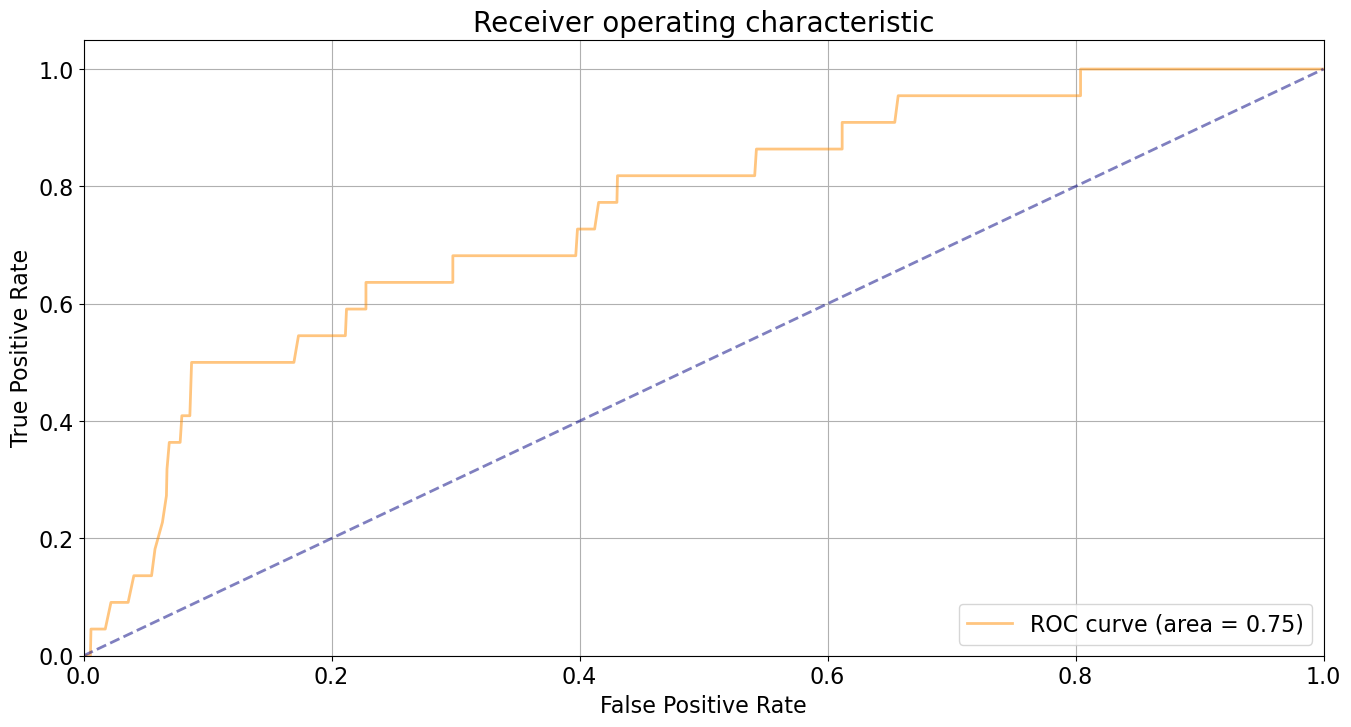

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
lw=2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [46]:
# и это без подбора порога по вероятности

In [47]:
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

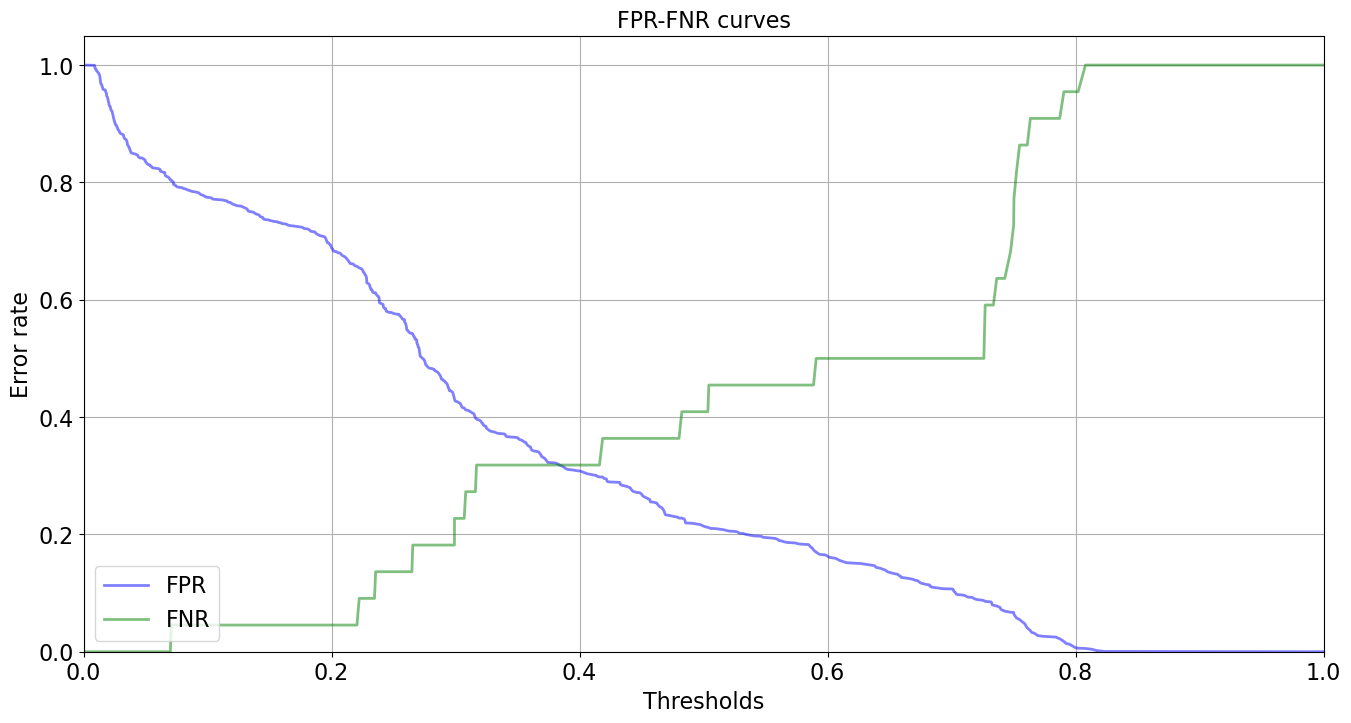

In [48]:
plt.figure(figsize=(16, 8))
lw=2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Thresholds', fontsize=16)
plt.ylabel('Error rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=16)
plt.legend(loc='lower left', fontsize=16)
plt.show()

In [49]:
from catboost.utils import select_threshold

fnr_boundary = select_threshold(model=model, data=eval_pool, FNR=0.1)

print(fnr_boundary)
print(select_threshold(model=model, data=eval_pool, FPR=0.1))

0.2346328818402823
0.7037868099576967


In [50]:
## считаем метрики

In [51]:
def model_metrics(model, test_sample, y_test, boundary):

    probabilities_pred = model.predict_proba(test_sample)[:,1]
    auc_roc = roc_auc_score(y_test, probabilities_pred)
    print(f'Roc Auc {auc_roc}')

    y_pred = np.where(probabilities_pred > boundary, 1, 0)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy = (tn + tp) / (tn + fp + fn + tp)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    

    FPR = fp / (fp + tn)
    FNR = fn / (tp + fn)
    
    print(f'FPR {FPR:.2f}')
    
    print(f'FNR {FNR:.2f}')

    print(f'Accuracy {accuracy:.2f}')
    print(f'Precision {precision:.2f}')
    print(f'Recall {recall:.2f}')

In [52]:
model_metrics(model, X_test, y_test,fnr_boundary)

Roc Auc 0.7546942453581458
FPR 0.61
FNR 0.09
Accuracy 0.39
Precision 0.01
Recall 0.91


In [53]:
# мы хотим максимизировать recall -> лучше предсказывать 1 там, где будет 0, чем предсказывать 0 там, где будет 1
# поэтому нам ок такие значения

### Отбор коммуникационных фичей

In [54]:
import matplotlib.pyplot as plt
import shap

In [55]:
# feature impotance(сплит и гейн),
# permutatioon importance
# shap (интерпретация)
# -> почитать и углубиться

In [56]:
model.get_feature_importance(prettified=True, type = 'PredictionValuesChange')[:10]

,Feature Id,Importances
0,min_weeks_diff_sp_del,18.369770
1,min_date_diff_sp_del,17.683725
2,max_weeks_diff_sp_del,13.637285
3,max_date_diff_sp_del,13.116536
4,weekend_delivery_sum,4.709911
5,n_communications,4.012964
6,Friday_sum,3.843588
7,Tuesday_sum,3.437676
8,avg_days_diff_sp_del,2.896509
9,Thursday_sum,2.722557


Text(0.5, 1.0, 'SHAP Importance')

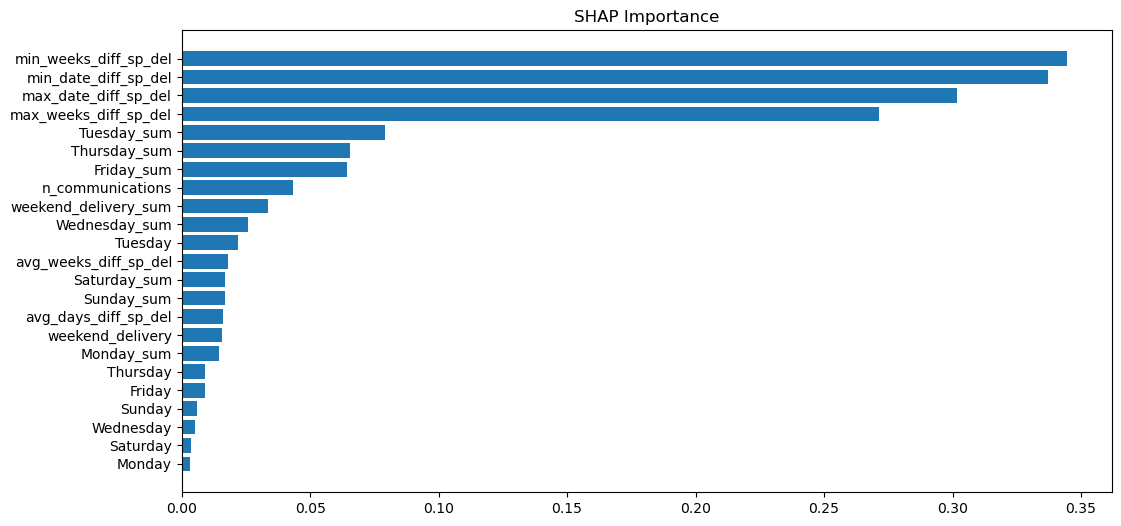

In [57]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('SHAP Importance')


In [58]:
# => отбираем фичи:
# min_weeks_diff_sp_del
# friday_sum
# tuesday_sum
# weekend_delivery_sum

## Классификатор на всех изначальных + топ коммуникационных фичей

In [59]:
# собираю датасет -> все фичи на первую дату delivery + отобранные коммуникационные фичи

In [60]:
# => отбираем фичи:
# min_weeks_diff_sp_del
# friday_sum
# tuesday_sum
# weekend_delivery_sum

In [61]:
df_new = df1[df1.previous_delivery_date.isna()].copy()

In [62]:
float_columns = df.select_dtypes(include=float).columns
# 'name_of_month'
selected_columns = ['client_id'] + list(float_columns)
df_new = df_new[selected_columns].merge(f4).merge(f11).merge(f9[['client_id','Friday_sum','Tuesday_sum']]).merge(trg)
# df_new

In [63]:
# Split your data into features and target
X = df_new.drop(['conv_flg'], axis=1)
y = df_new['conv_flg']
X.fillna(0,inplace = True)

In [64]:
X_train_, X_test_, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

In [65]:
X_train, X_test = X_train_.drop(['client_id'], axis=1), X_test_.drop(['client_id'], axis=1)

In [66]:
cat_features = []

In [67]:
params = {
    'loss_function': 'Logloss',
    'iterations': 1000,
    'custom_loss': ['AUC','Recall'],
    'random_seed': 1,
    'learning_rate': 0.01,
    'use_best_model' : True,
    'auto_class_weights' : 'Balanced',
}

cv_data, models = cv(
    params=params,
    pool=Pool(X_train, label=y_train, cat_features=cat_features),
    fold_count=5,
    shuffle=True, 
    partition_random_seed=10,
    plot=True,
    early_stopping_rounds = 50,
    stratified=True, 
    verbose=False,
    return_models=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.6386281493
bestIteration = 79

Training on fold [1/5]

bestTest = 0.6180754246
bestIteration = 151

Training on fold [2/5]

bestTest = 0.6326281209
bestIteration = 121

Training on fold [3/5]

bestTest = 0.5662319477
bestIteration = 393

Training on fold [4/5]

bestTest = 0.6062262453
bestIteration = 188



In [68]:
model = to_classifier(models[3])

In [69]:
eval_pool = Pool(X_test, y_test, cat_features=cat_features)
curve = get_roc_curve(model, eval_pool)

In [70]:
(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

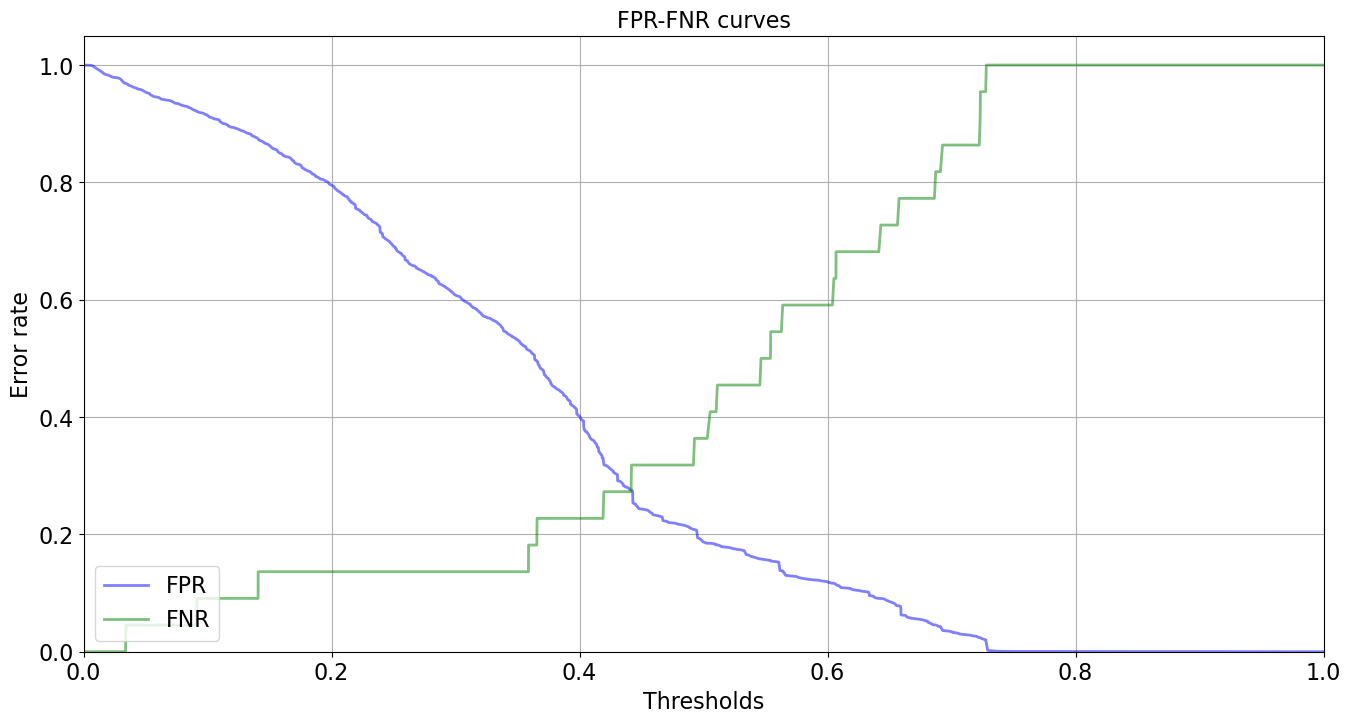

In [71]:
plt.figure(figsize=(16, 8))
lw=2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Thresholds', fontsize=16)
plt.ylabel('Error rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=16)
plt.legend(loc='lower left', fontsize=16)
plt.show()

In [72]:
fnr_boundary = select_threshold(model=model, data=eval_pool, FNR=0.1)

print(fnr_boundary)

0.14077117573270492


In [73]:
model_metrics(model, X_test, y_test,fnr_boundary)

Roc Auc 0.7295255459155874
FPR 0.87
FNR 0.09
Accuracy 0.13
Precision 0.01
Recall 0.91


### Отбор важнейших фичей

In [74]:
model.get_feature_importance(prettified=True)[:5]

,Feature Id,Importances
0,min_weeks_diff_sp_del,35.182862
1,specific_picks__g_client__sp_region_msc_obl__c...,1.379996
2,specific_picks__g_client__sp_buy_rent__count__...,1.325030
3,calls__g_client__call_date__min__365D,1.079235
4,specific_picks__g_client__sp_acquisition_mysel...,1.069699


In [75]:
# model.get_feature_importance(prettified=True)[:30]['Feature Id'].values

In [76]:
imp_initial_features = [feature for feature in model.get_feature_importance(prettified=True)[:24]['Feature Id'].values if feature not in (
    'min_weeks_diff_sp_del',
    'Friday_sum',
    'Tuesday_sum')]

imp_com_features = ['min_weeks_diff_sp_del',
    'Friday_sum',
    'Tuesday_sum']

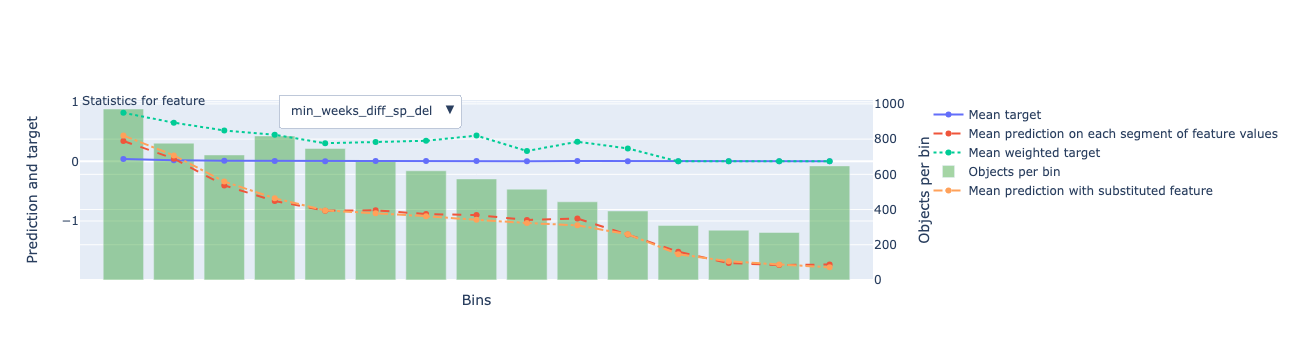

{'min_weeks_diff_sp_del': {'borders': array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
         11.5, 12.5, 13.5], dtype=float32),
  'binarized_feature': array([ 5,  4,  0, ...,  3,  4, 14]),
  'mean_target': array([0.03913491, 0.01673102, 0.00985915, 0.00733496, 0.00401606,
         0.00441176, 0.00483871, 0.00696864, 0.00193798, 0.0045045 ,
         0.00255102, 0.        , 0.        , 0.        , 0.        ],
        dtype=float32),
  'mean_weighted_target': array([0.8154451 , 0.64862204, 0.5192803 , 0.4449405 , 0.30431733,
         0.3246567 , 0.34532553, 0.43223557, 0.17399694, 0.32925498,
         0.21719272, 0.        , 0.        , 0.        , 0.        ],
        dtype=float32),
  'mean_prediction': array([ 0.34227785,  0.04593714, -0.40328798, -0.66420037, -0.8266661 ,
         -0.82162917, -0.88343495, -0.90001386, -0.9825651 , -0.9594576 ,
         -1.2281543 , -1.5155499 , -1.7061313 , -1.7382215 , -1.730322  ],
        dtype=float32),
  'objects_per_

In [77]:
model.calc_feature_statistics(X_train, y_train, feature = imp_com_features)

In [78]:
# max_date_diff_sp_del
# min_date_diff_sp_del
# weekend_delivery_sum
# tuesday_sum
# Friday_sum

## Переходим к скорингу, оставили только топ признаки, перебираем коммуникационные

### Фитим и калибруем модель

In [79]:
df_final = df_new[['client_id','conv_flg'] + imp_initial_features + imp_com_features].copy()
# df_final.head()

In [80]:
# Split your data into features and target
X = df_final.drop(['conv_flg'], axis=1)
y = df_final['conv_flg']
X.fillna(0,inplace = True)

In [81]:
X_train_, X_test_, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 10)

In [82]:
X_train, X_test = X_train_.drop(['client_id'], axis=1), X_test_.drop(['client_id'], axis=1)

In [83]:
cat_features = []

In [84]:
params = {
    'loss_function': 'Logloss',
    'iterations': 1000,
    'custom_loss': ['AUC','Recall'],
    'random_seed': 1,
    'learning_rate': 0.005,
    'use_best_model' : True,
    'auto_class_weights' : 'Balanced',
}

cv_data, models = cv(
    params=params,
    pool=Pool(X_train, label=y_train, cat_features=cat_features),
    fold_count=5,
    shuffle=True, 
    partition_random_seed=10,
    plot=True,
    early_stopping_rounds = 50,
    stratified=True, 
    verbose=False,
    return_models=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.5842792849
bestIteration = 237

Training on fold [1/5]

bestTest = 0.5985971239
bestIteration = 206

Training on fold [2/5]

bestTest = 0.6107444829
bestIteration = 216

Training on fold [3/5]

bestTest = 0.6140524373
bestIteration = 186

Training on fold [4/5]

bestTest = 0.5437679828
bestIteration = 344



In [85]:
model = to_classifier(models[4])

In [86]:
eval_pool = Pool(X_test, y_test, cat_features=cat_features)
curve = get_roc_curve(model, eval_pool)

In [87]:
(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

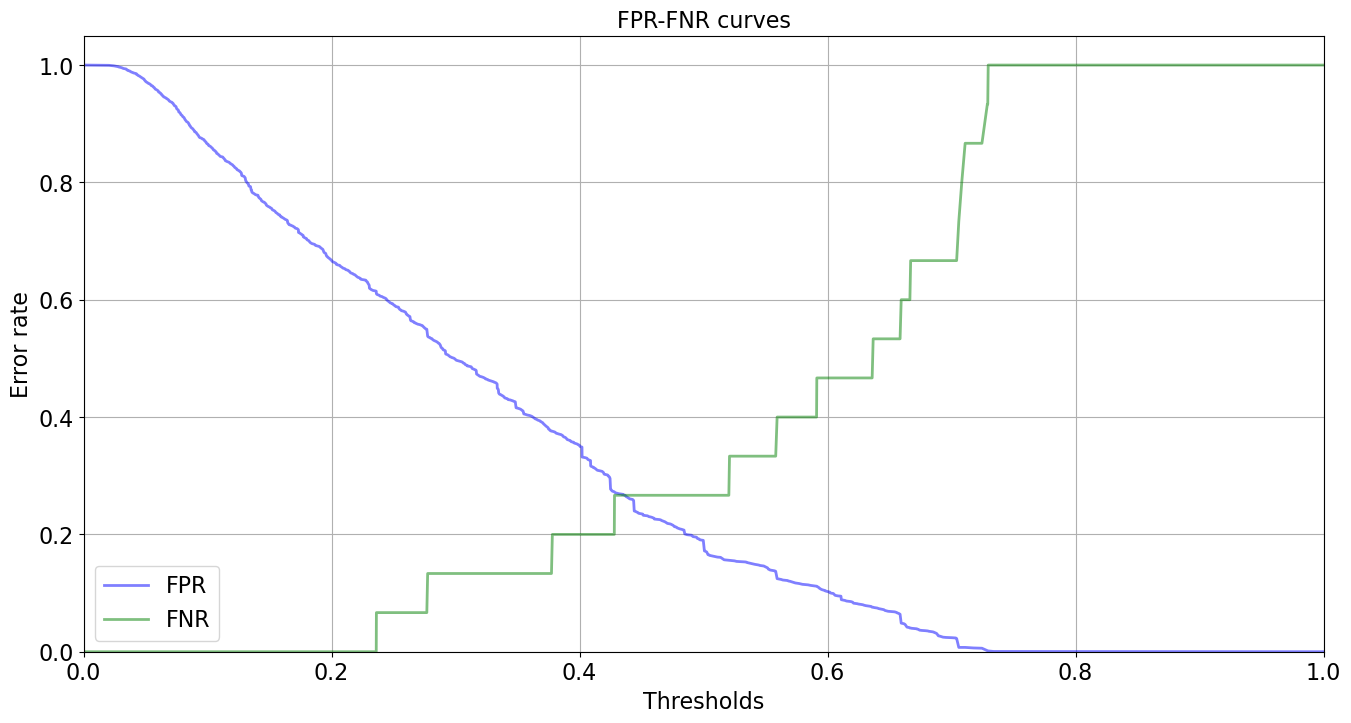

In [88]:
plt.figure(figsize=(16, 8))
lw=2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Thresholds', fontsize=16)
plt.ylabel('Error rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=16)
plt.legend(loc='lower left', fontsize=16)
plt.show()

In [89]:
fnr_boundary = select_threshold(model=model, data=eval_pool, FNR=0.1)

print(fnr_boundary)

0.276849991153118


In [90]:
model_metrics(model, X_test, y_test,fnr_boundary)

Roc Auc 0.8393229166666667
FPR 0.55
FNR 0.07
Accuracy 0.45
Precision 0.01
Recall 0.93


In [91]:
# Калибровка моделей по вероятностям
# https://scikit-learn.org/stable/modules/calibration.html

In [92]:
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

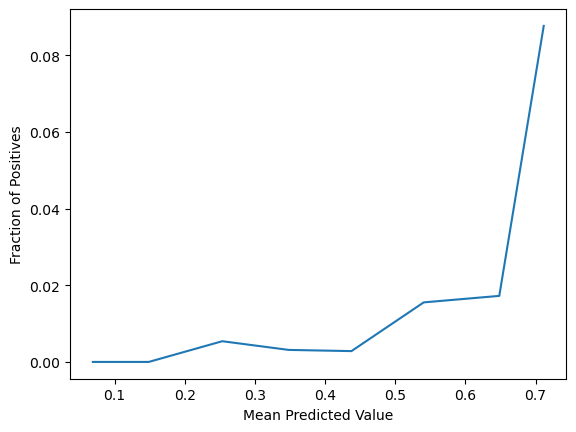

In [93]:
# До калибровки
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Plot the calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_pred_proba, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives)
plt.xlabel("Mean Predicted Value")
plt.ylabel("Fraction of Positives")
plt.show()

In [94]:
# Create a calibrated classifier
calibrated_clf = CalibratedClassifierCV(model, method="isotonic", cv='prefit')
calibrated_clf.fit(X_train, y_train)

# Evaluate the calibrated classifier
y_pred = calibrated_clf.predict(X_test)
y_pred_proba = calibrated_clf.predict_proba(X_test)[:, 1]

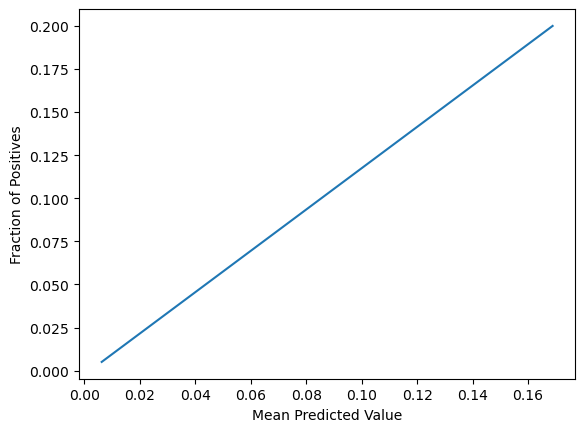

In [95]:
# После калибровки

# Plot the calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_pred_proba, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives)
plt.xlabel("Mean Predicted Value")
plt.ylabel("Fraction of Positives")
plt.show()

In [96]:
# Нашли порог FNR <= 0.1
fnr_boundary = 0.0009

In [97]:
final_model = calibrated_clf

In [98]:
# метрики не изменились после калибровки, всё ок
model_metrics(final_model, X_test, y_test,fnr_boundary)

Roc Auc 0.8388786764705882
FPR 0.55
FNR 0.07
Accuracy 0.45
Precision 0.01
Recall 0.93


In [99]:
# метрики на трейне
# метрики не изменились после калибровки, всё ок
model_metrics(final_model, X_train, y_train,fnr_boundary)

Roc Auc 0.9077451463435088
FPR 0.55
FNR 0.01
Accuracy 0.46
Precision 0.02
Recall 0.99


### BASELINE

In [100]:
## BASELINE
# Коммуникация в 1 день после sp
# найти для каждого клиента из df_new дату sp
df_upd = df1[['client_id','min_sp_created_on']].drop_duplicates().copy()
df_upd.reset_index(inplace=True)

df_upd['min_weeks_diff_sp_del'] = 0

df_upd['first_com'] = df_upd.min_sp_created_on + pd.Timedelta(days=1)
df_upd['first_com_dow'] = df_upd['first_com'].dt.day_name()

df_upd['Tuesday_sum'] = df_upd.apply(lambda row: 1 if row['first_com_dow'] == 'Tuesday' else 0, axis=1).astype(int)
df_upd['Friday_sum'] = df_upd.apply(lambda row: 1 if row['first_com_dow'] == 'Friday' else 0, axis=1).astype(int)

In [101]:
X_test_baseline_ = pd.merge(X_test_.drop(['min_weeks_diff_sp_del','Friday_sum', 'Tuesday_sum'], axis = 1),
    df_upd[['client_id','min_weeks_diff_sp_del','Friday_sum','Tuesday_sum']],on = 'client_id')
X_test_baseline = X_test_baseline_.drop('client_id', axis=1)

In [102]:
# BASELINE RESULTS
baseline_results = final_model.predict_proba(X_test_baseline)[:,1]
baseline_mean = np.mean(baseline_results)
baseline_mean

0.03902441935262816

In [103]:
# client_id predicted_prob_baseline
baseline_res_per_client = pd.DataFrame({'client_id':X_test_baseline_['client_id'],
              'predicted_prob':baseline_results})
baseline_res_per_client

,client_id,predicted_prob
0,f83491a897698313dc423f90dbf55daa,0.056122
1,bf0e54981f9add5be5230a4b0565e83f,0.000446
2,73eeed8d1da8e32e630ba0ecde0bc6c6,0.015075
3,8490611803d5d99dcbbcd1ec8cf4f690,0.168831
4,5cd0aa1cc454e3983c17757a59264cd5,0.000446
...,...,...
2186,69d744bae3771e52a43312558f04e3f7,0.028322
2187,d4ab6ae422103ce46c5766cca82a11d3,0.056122
2188,b077bc91d484239d13115c4d645ae81e,0.056122
2189,544a8e9867e4f6b58efe39bf0330d601,0.035897


### Скоринг

In [104]:
# min_weeks_diff_sp_del от 0 до 17
# Friday_sum 0 1 2
# Tuesday_sum 0 1 2

In [105]:
min_weeks = np.arange(0,18)
friday = np.arange(0,2)
tuesday = np.arange(0,2)

In [106]:
df1 = pd.DataFrame({'min_weeks_diff_sp_del': min_weeks,})
df2 = pd.DataFrame({'Friday_sum': friday,})
df3 = pd.DataFrame({'Tuesday_sum': tuesday,})

In [107]:
# Perform cross join
df_cross = pd.merge(df1, df2, how='cross')
df_cross = pd.merge(df_cross, df3, how='cross')
df_cross

,min_weeks_diff_sp_del,Friday_sum,Tuesday_sum
0,0,0,0
1,0,0,1
2,0,1,0
3,0,1,1
4,1,0,0
...,...,...,...
67,16,1,1
68,17,0,0
69,17,0,1
70,17,1,0


In [108]:
X_test_scoring_ = pd.merge(X_test_.drop(['min_weeks_diff_sp_del','Friday_sum', 'Tuesday_sum'], axis = 1), df_cross, how='cross')
X_test_scoring = X_test_scoring_.drop('client_id', axis=1)

In [109]:
# Scoring RESULTS
scor_results = final_model.predict_proba(X_test_scoring)[:,1]

In [110]:
# client_id predicted_prob_baseline
scoring_res_per_client = pd.DataFrame({'client_id':X_test_scoring_['client_id'],
              'predicted_prob':scor_results})
scoring_res_per_client

,client_id,predicted_prob
0,f83491a897698313dc423f90dbf55daa,0.056122
1,f83491a897698313dc423f90dbf55daa,0.168831
2,f83491a897698313dc423f90dbf55daa,0.035897
3,f83491a897698313dc423f90dbf55daa,0.035897
4,f83491a897698313dc423f90dbf55daa,0.028322
...,...,...
157747,d172500d2af908acd8ec950abad70121,0.000000
157748,d172500d2af908acd8ec950abad70121,0.000000
157749,d172500d2af908acd8ec950abad70121,0.000446
157750,d172500d2af908acd8ec950abad70121,0.000000


In [111]:
best_scores = scoring_res_per_client.groupby('client_id').max('predicted_prob').reset_index()
best_scores

,client_id,predicted_prob
0,00015b188cd3369bf0b8c75aab89a79a,0.028322
1,002de237c7c88b4cb65ddb11d0862d65,0.168831
2,00561c58043d666ab123124eb72517c7,0.035897
3,0075477d7ee6f071bffa666fa582d08f,0.028322
4,00b2c220ac7a748bc343b131b38f3687,0.056122
...,...,...
2186,ff97001f696ecbd35abad01b4448e7f8,0.013314
2187,ff9c1096e960aa2eefddec857ab79143,0.015075
2188,ffa151362bed279666a596b332f47d46,0.168831
2189,ffbf2a80951cf8557f75a67d2b393a47,0.028322


In [112]:
best_scores_mean = np.mean(best_scores['predicted_prob'])

best_scores_mean, best_scores_mean - baseline_mean

(0.07698946699476146, 0.0379650476421333)

### Рассчёт аплифтов в деньгах

In [113]:
fnr_boundary = 0.0009

In [114]:
# Смотрю по тестовой выборке
# Отбираю юзеров, которым мы предсказали 1в финальной модели
# Знаю, у кого из них реально 1, смотрю долю реальных 1 (TPR или Precision) и ошибок  (FPR)
# Количество предсказанных 1 * TPR = количество договоров
# (за скобками оставляем FNR, потому что по этой границе принимали решение)

# Теперь перехожу к бейзлайну и скорингу
# Предполагаю, что TPR не изменится
# С той же границой по FNR<=0.1, которую использовал на откалиброванной модели, делаю предсказания 0 и 1

# Теперь Baseline Pred 1 * Precision = Baseline договоров
# Теперь Best Scoring Pred 1 * Precision = После скоринга договоров

# Нормирую на количество юзеров в тесте => 
# Baseline конверсия в покупку = Baseline договоров / Юзеров в тесте
# После скоринга конверсия в покупку = Baseline договоров / Юзеров в тесте

In [115]:
# юзеров в тесте 2191

In [116]:
probabilities_pred = final_model.predict_proba(X_test_baseline)[:,1]
y_pred = np.where(probabilities_pred > fnr_boundary, 1, 0)
pd.Series(y_pred).value_counts()
# => 2096 Pred 1 Baseline

1    2096
0      95
Name: count, dtype: int64

In [117]:
best_scores[best_scores.predicted_prob > fnr_boundary]['predicted_prob'].count()
# => 2116 Pred 1 Baseline

2116

In [118]:
round(100 * 0.01 * 2096 / 2191,2)

0.96

In [119]:
round(100 * 0.01 * 2116 / 2191,2)

0.97

In [120]:
# => повышение конверсии на 0.01% => дополнительно 1 квартира из 10_000 пришедших пользователей

In [121]:
# Если допустить, что MAU самолёта 1000000, то в месяц сможем продать больше на 100 квартир